In [1]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
# Model imports
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# Data Generator setup - with augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2,
    rescale=1. / 255
)

# Load data
root_path = r'C:\Users\Anderson\Documents\GitHub\COMP9444_project\Dataset\Yoga-82\yoga_dataset_links_skeleton'  # Update with your path
train_ds = data_gen.flow_from_directory(
    root_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

valid_ds = data_gen.flow_from_directory(
    root_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Get number of classes
n_classes = len(train_ds.class_indices)


def lr_schedule(epoch):
    initial_lr = 0.001

    if epoch < 5:
        return initial_lr
    elif epoch < 15:
        return initial_lr * 0.5
    elif epoch < 30:
        return initial_lr * 0.1
    elif epoch < 50:
        return initial_lr * 0.05
    elif epoch < 70:
        return initial_lr * 0.01
    else:
        return initial_lr * 0.005


def build_model(trainable=False, learning_rate=0.001):
    base_model = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3)
    )

    base_model.trainable = trainable

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def train_model():
    # stage1
    print("Stage 1: Training top layers...")
    model = build_model(trainable=False, learning_rate=0.001)

    callbacks_stage1 = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            'yoga_pose_model_stage1.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    history1 = model.fit(
        train_ds,
        epochs=30,
        validation_data=valid_ds,
        callbacks=callbacks_stage1
    )

    # stage2
    print("\nStage 2: Fine-tuning the entire model...")
    model = build_model(trainable=True, learning_rate=0.0001)

    for layer in model.layers[0].layers[:-20]:
        layer.trainable = False

    callbacks_stage2 = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            'yoga_pose_model_stage2.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=7,
            min_lr=1e-7,
            verbose=1
        ),
        LearningRateScheduler(lr_schedule, verbose=1)
    ]

    history2 = model.fit(
        train_ds,
        epochs=70,
        validation_data=valid_ds,
        callbacks=callbacks_stage2
    )

    return model, history1, history2


Found 13145 images belonging to 82 classes.
Found 3250 images belonging to 82 classes.


In [3]:

def plot_training_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy']), color='g', linestyle='--', label='Stage Change')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='g', linestyle='--', label='Stage Change')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_model(model, test_ds):
    print("\nEvaluating model...")
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    return test_loss, test_accuracy


if __name__ == "__main__":
    print("Starting training process...")
    print(f"Number of classes: {n_classes}")

Starting training process...
Number of classes: 82


Stage 1: Training top layers...
Epoch 1/30
411/411 [==============================] - ETA: 0s - loss: 3.8761 - accuracy: 0.1092
Epoch 1: val_accuracy improved from -inf to 0.23569, saving model to yoga_pose_model_stage1.h5
411/411 [==============================] - 225s 537ms/step - loss: 3.8761 - accuracy: 0.1092 - val_loss: 3.2156 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 2/30
411/411 [==============================] - ETA: 0s - loss: 3.2308 - accuracy: 0.2096
Epoch 2: val_accuracy improved from 0.23569 to 0.28892, saving model to yoga_pose_model_stage1.h5
411/411 [==============================] - 298s 725ms/step - loss: 3.2308 - accuracy: 0.2096 - val_loss: 2.8166 - val_accuracy: 0.2889 - lr: 0.0010
Epoch 3/30
411/411 [==============================] - ETA: 0s - loss: 3.0041 - accuracy: 0.2483
Epoch 3: val_accuracy improved from 0.28892 to 0.33169, saving model to yoga_pose_model_stage1.h5
411/411 [==============================] - 260s 632ms/step - loss: 3.0041 - accuracy: 0.2483 

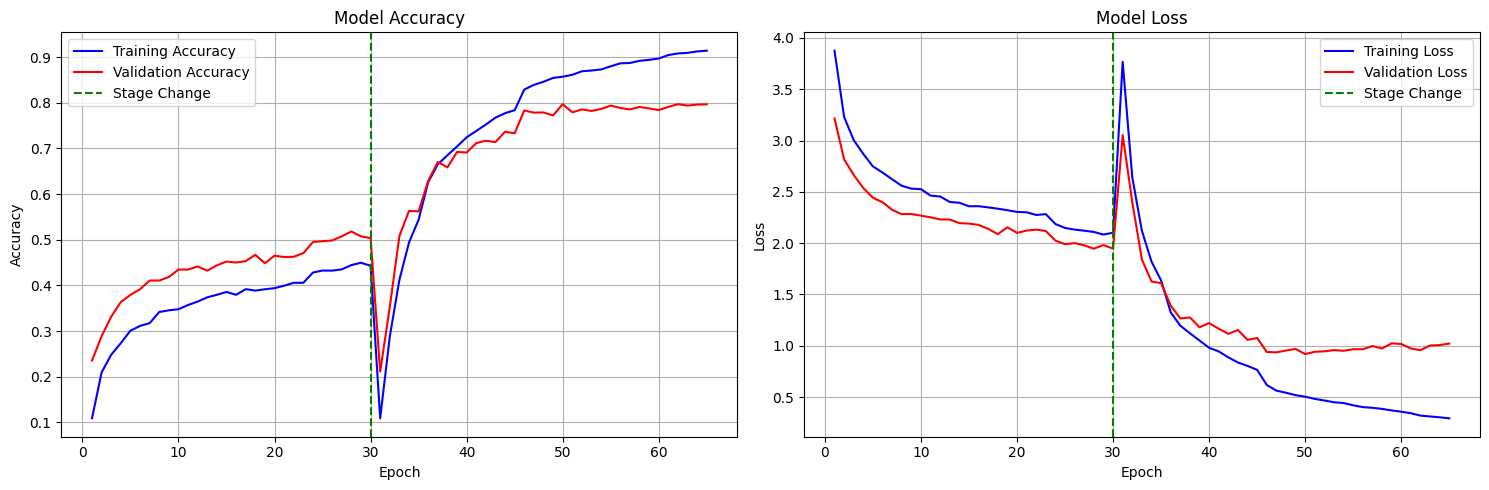


Evaluating model...
102/102 [==============================] - 29s 279ms/step - loss: 0.9474 - accuracy: 0.7843
Test Accuracy: 78.43%
Test Loss: 0.9474

Model saved to yoga_pose_model_final.h5

Training Summary:
Total epochs trained: 65
Best validation accuracy: 79.69%
Final validation accuracy: 78.43%


In [4]:

    model, history1, history2 = train_model()

    plot_training_history(history1, history2)

    final_loss, final_accuracy = evaluate_model(model, valid_ds)

    model_save_path = 'yoga_pose_model_final.h5'
    model.save(model_save_path)
    print(f"\nModel saved to {model_save_path}")

    print("\nTraining Summary:")
    print(f"Total epochs trained: {len(history1.history['accuracy']) + len(history2.history['accuracy'])}")
    print(
        f"Best validation accuracy: {max(history1.history['val_accuracy'] + history2.history['val_accuracy']) * 100:.2f}%")
    print(f"Final validation accuracy: {final_accuracy * 100:.2f}%")